In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
from sklearn.metrics import roc_curve, auc

from sklearn import svm

C:\Users\da1933\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [16]:
def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")

In [4]:
directory='c:/users/da1933/desktop/cds/ids_project/'
#directory='~/desktop/idsproject/'

df1=pd.read_csv(directory+'wine/winemag-data-130k-v2.csv',index_col=0)
df2=pd.read_csv(directory+'wine/winemag-data_first150k.csv',index_col=0)
df=pd.concat([df1.drop(['taster_name','taster_twitter_handle','title'],axis=1),df2]).reset_index(drop=True)

In [5]:
df['over90']=df['points'].apply(lambda x: 1 if x>=90 else 0)

In [6]:
varietal_counts=pd.DataFrame({'grape':df['variety'].value_counts().index,'count':df['variety'].value_counts().values})

In [7]:
varietals=set(varietal_counts[varietal_counts['count']>=50]['grape'])

In [8]:
l_enc = LabelEncoder()
col1 = l_enc.fit_transform(df['country'].astype(str))
col2 = l_enc.fit_transform(df['variety'].astype(str))
col3 = l_enc.fit_transform(df['province'].astype(str))
df_enc = pd.DataFrame({'enc_country':col1,'enc_variety':col2,'enc_province':col3})

df=pd.concat([df,df_enc],axis=1)

#one hot encoding
enc = OneHotEncoder()
X_enc = enc.fit_transform(X)

X_enc

### Train-Test-Split

In [9]:
df['textlen']=df['description'].apply(lambda x: len(x))

df=df.set_index(np.random.permutation(df.index.values)).sort_index()

# Determine split index:
split_index=int(np.round(df.shape[0]*.8))

# Assign training and testing datasets based on split index
train_df=df.iloc[:split_index,:]
test_df=df.iloc[split_index:,:]

trainX=train_df.drop(['points','price','description'],axis=1)
trainY=train_df[['points','price','over90']]
testX=test_df.drop(['points','price','description'],axis=1)
testY=test_df[['points','price','over90']]

### Random Forest Regression

In [10]:
clf=RandomForestRegressor()
clf.fit(trainX[['enc_country','enc_province','enc_variety','textlen']],trainY['points'])
score=clf.score(testX[['enc_country','enc_province','enc_variety','textlen']],testY['points'])

In [11]:
score

0.5301941351309649

In [ ]:
scores=[]
d=[50,100,200,300,400,500]
l=[5,10,20]
for depth in d:
    for leaves in l:
        clf=RandomForestRegressor(max_depth=depth,min_samples_leaf=leaves)
        clf.fit(trainX[['enc_province','enc_variety','textlen']],trainY['points'])
        score=clf.score(testX[['enc_province','enc_variety','textlen']],testY['points'])
        scores.append((depth,leaves,score))
        print(depth,leaves,score)

### Random Forest Classifier

In [43]:
rfc=RandomForestClassifier(criterion='entropy')

In [44]:
rfc.fit(trainX[['enc_country','enc_province','enc_variety','textlen']],trainY['over90'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
rfc.score(testX[['enc_country','enc_province','enc_variety','textlen']],testY['over90'])

0.7935386258454966

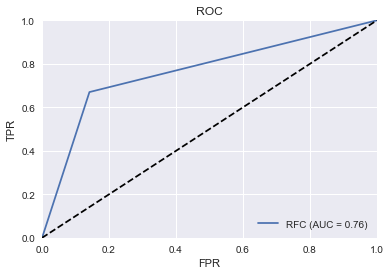

In [46]:
plotAUC(testY['over90'],rfc.predict(testX[['enc_country','enc_province','enc_variety','textlen']]),'RFC')

In [66]:
rfc_preds=rfc.predict(testX[['enc_country','enc_province','enc_variety','textlen']])

## Gradient Boosted Classifier

In [47]:
gbc=GradientBoostingClassifier()

In [48]:
gbc.fit(trainX[['enc_country','enc_province','enc_variety','textlen']],trainY['over90'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [49]:
gbc.score(testX[['enc_country','enc_province','enc_variety','textlen']],testY['over90'])

0.7563011747953008

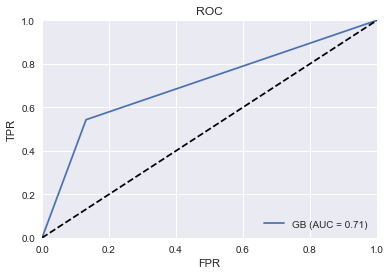

In [50]:
plotAUC(testY['over90'],gbc.predict(testX[['enc_country','enc_province','enc_variety','textlen']]),'GB')

In [67]:
gbc_preds=gbc.predict(testX[['enc_country','enc_province','enc_variety','textlen']])

## SVM - VERY time consuming

In [93]:
clf = svm.SVC(kernel='rbf')

In [ ]:
clf.fit(trainX[['enc_country','enc_province','enc_variety','textlen']],trainY['over90'])  

In [78]:
preds=clf.predict(testX[['enc_country','enc_province','enc_variety','textlen']])

In [80]:
sum(preds==testY['over90'])/len(testY['over90'])

0.7334384858044164

In [84]:
q=df['over90'].value_counts().values

In [86]:
q[0]/sum(q)

0.6226465903932416

In [88]:
plot_AUC()

0.29745325844425635

## KNN

In [51]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(trainX[['enc_country','enc_province','enc_variety','textlen']],trainY['over90'])

knn.score(testX[['enc_country','enc_province','enc_variety','textlen']],testY['over90'])

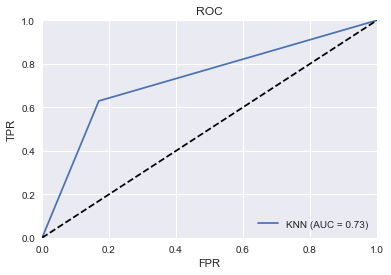

In [54]:
plotAUC(testY['over90'],knn.predict(testX[['enc_country','enc_province','enc_variety','textlen']]),'KNN')

In [68]:
knn_preds=knn.predict(testX[['enc_country','enc_province','enc_variety','textlen']])

### Logistig Regression

In [92]:
lr = LogisticRegression()

lr.fit(trainX[['enc_country','enc_province','enc_variety','textlen']],trainY['over90'])

lr.score(testX[['enc_country','enc_province','enc_variety','textlen']],testY['over90'])

0.7245461018155928

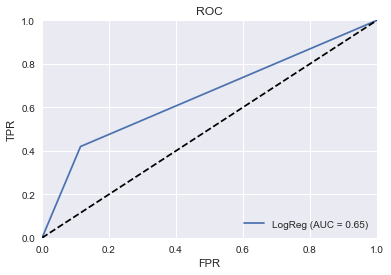

In [88]:
plotAUC(testY['over90'],lr.predict(testX[['enc_country','enc_province','enc_variety','textlen']]),'LogReg')

In [89]:
lr_preds=lr.predict(testX[['enc_country','enc_province','enc_variety','textlen']])

### To add later ? Analyze how/why rfc, gbc, and knn prediction are different?

In [91]:
print('RFC and GBC make {0:.2f}% similar predictions'.format(100*sum(rfc_preds==gbc_preds)/len(testY['over90'])))
print('RFC and KNN make {0:.2f}% similar predictions'.format(100*sum(rfc_preds==knn_preds)/len(testY['over90'])))
print('RFC and LR make {0:.2f}% similar predictions'.format(100*sum(rfc_preds==lr_preds)/len(testY['over90'])))
print('GBC and KNN make {0:.2f}% similar predictions'.format(100*sum(gbc_preds==knn_preds)/len(testY['over90'])))
print('GBC and LR make {0:.2f}% similar predictions'.format(100*sum(gbc_preds==lr_preds)/len(testY['over90'])))
print('KNN and LR make {0:.2f}% similar predictions'.format(100*sum(knn_preds==lr_preds)/len(testY['over90'])))

RFC and GBC make 82.29% similar predictions
RFC and KNN make 87.30% similar predictions
RFC and LR make 77.08% similar predictions
GBC and KNN make 80.77% similar predictions
GBC and LR make 87.27% similar predictions
KNN and LR make 76.61% similar predictions
